In [1]:
# importación de librerias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [2]:
import tensorflow as tf

# Verifica los dispositivos disponibles
print("Dispositivos disponibles:")
for device in tf.config.list_physical_devices():
    print(device)
    
# Verifica si se está utilizando Metal
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
else:
    print("GPU no está disponible.")

# Configuración para limitar el crecimiento de memoria
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configura TensorFlow para que use toda la memoria de GPU disponible
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Dispositivos disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU está disponible.


In [98]:
!curl -L -o brain_tumor_dataset.zip https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/refs/heads/master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9594k    0 9594k    0     0  49691      0 --:--:--  0:03:17 --:--:-- 46127-:--:--  0:00:16 --:--:-- 3864456645      0 --:--:--  0:00:32 --:--:-- 56036:48 --:--:-- 48618  0  53571      0 --:--:--  0:01:05 --:--:-- 50233--:--  0:01:28 --:--:-- 555610:02:14 --:--:-- 52567  0  49701      0 --:--:--  0:02:40 --:--:-- 443610:02:51 --:--:-- 517999140--:--:-- 37264^C


In [7]:
import zipfile
import os

# Rutas
zip_path = 'brain_tumor_dataset.zip'
extract_to = 'data'

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('models'):
    os.makedirs('models')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verificar los archivos extraídos
extracted_files = os.listdir(extract_to)
print(extracted_files)


['Brain-Tumor-Classification-DataSet-master']


In [6]:
# rutas
TEST_PATH = './data/Brain-Tumor-Classification-DataSet-master/Testing'
TRAIN_PATH = './data/Brain-Tumor-Classification-DataSet-master/Training'
# tamaño de imagen
IMG_SIZE = (224,224)
#  categorias
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

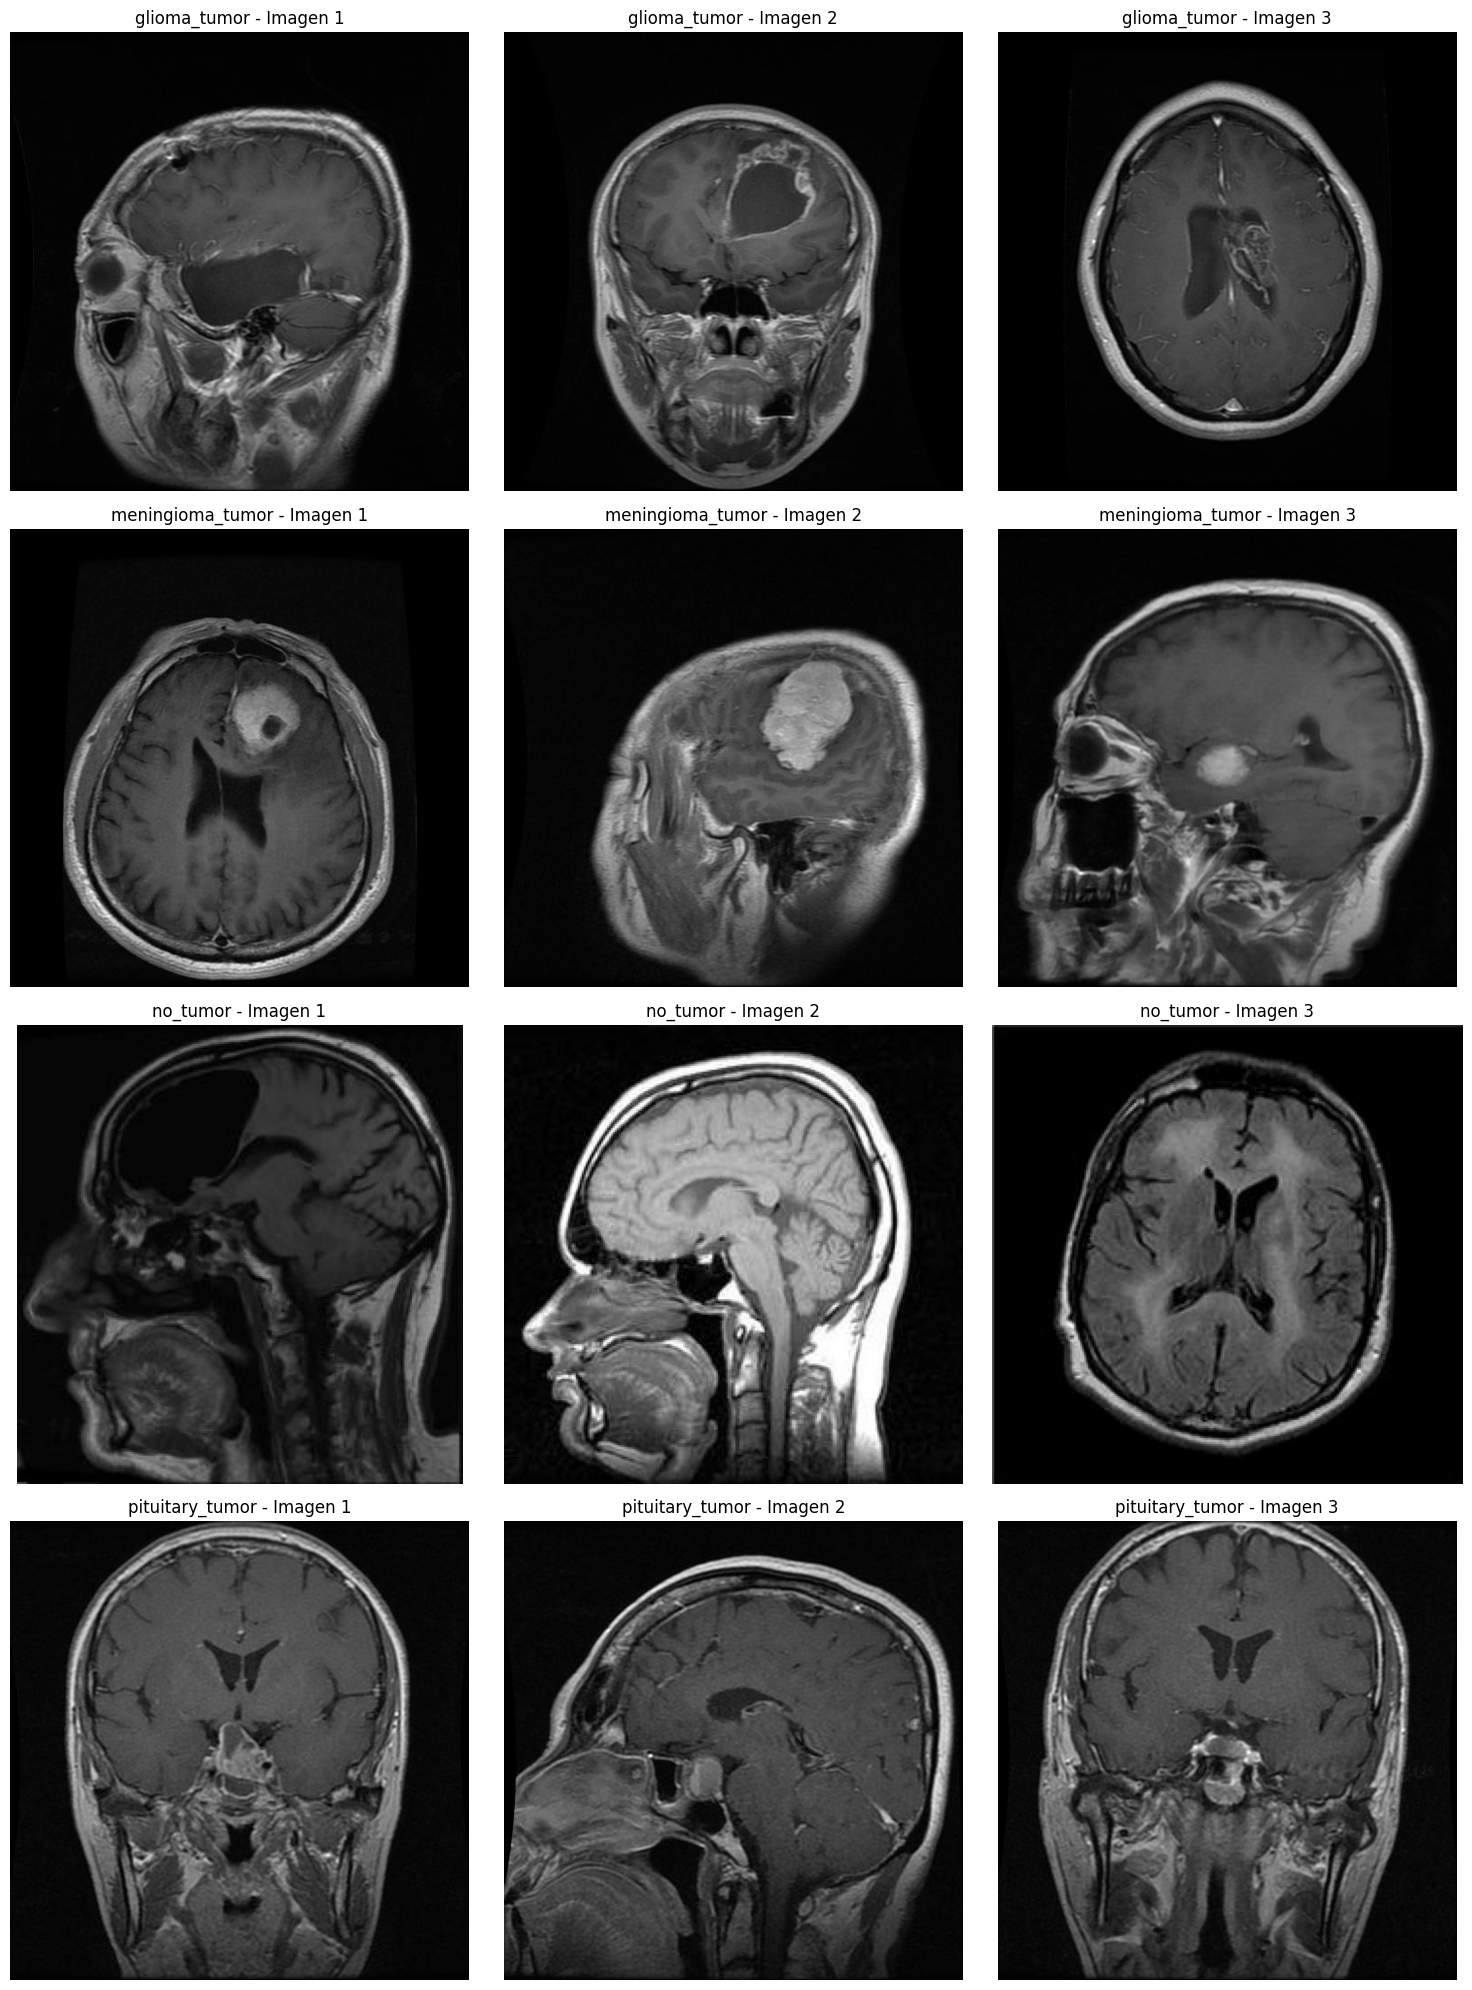

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Definir la función para mostrar las imágenes en una grilla
def show_images_in_grid(image_paths, titles, images_per_row=3):
    num_images = len(image_paths)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    plt.figure(figsize=(15, 5 * num_rows))
    
    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR a RGB para matplotlib
        
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image)
        plt.title(titles[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Recopilar las rutas de las imágenes y los títulos
image_paths = []
titles = []

for category in CATEGORIES:
    image_files = os.listdir(os.path.join(TRAIN_PATH, category))
    num_images_to_show = min(len(image_files), 3)  # Mostrar hasta 3 imágenes por categoría
    
    for i in range(num_images_to_show):
        image_path = os.path.join(TRAIN_PATH, category, image_files[i])
        image_paths.append(image_path)
        titles.append(f"{category} - Imagen {i + 1}")

# Mostrar las imágenes en una grilla
show_images_in_grid(image_paths, titles, images_per_row=3)


### Funciones a utilizar

In [7]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

def create_dataset(data_path, categories, img_size):
    """Genera un dataset a partir de imágenes en un directorio dado."""
    data = []

    for category in categories:
        path = os.path.join(data_path, category)
        class_id = categories.index(category)
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path, img)
            img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img_array is not None:
                resized_array = cv2.resize(img_array, img_size)  # (ancho, alto)
                data.append([resized_array, class_id])
            else:
                print(f"Error al cargar la imagen {img_path}")

    random.shuffle(data)

    # Separar imágenes y etiquetas
    X = np.array([item[0] for item in data])
    y = np.array([item[1] for item in data])
    
    return X, y

In [ ]:
!pip install seaborn

In [95]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,  Flatten, Input
from tensorflow.keras.models import Model

import seaborn as sns

class CustomModelCheckpoint(Callback):
    def __init__(self, save_path, monitor='val_accuracy', mode='max', verbose=1):
        super(CustomModelCheckpoint, self).__init__()
        self.save_path = save_path
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = None
        self.epoch = 0  # Inicializar el contador de épocas
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch  # Actualizar el contador de épocas
        current = logs.get(self.monitor)
        if current is None:
            return
        
        if self.best is None:
            self.best = current
            self._save_model()
        else:
            if self.mode == 'max' and current > self.best:
                self.best = current
                self._save_model()
            elif self.mode == 'min' and current < self.best:
                self.best = current
                self._save_model()
    
    def _save_model(self):
        if self.verbose > 0:
            print(f'\nEpoch {self.epoch + 1}: {self.monitor} improved, saving model to {self.save_path}')
        self.model.save(self.save_path)

def load_pretrained_model(model_path):
    """Carga un modelo preentrenado desde un archivo .h5."""
    return load_model(model_path)

def display_images(images, labels, class_names, num_images=9):
    """Displays a grid of images with their labels."""
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        # Ensure labels are integers for indexing
        label_index = int(labels[i]) if isinstance(labels[i], (np.float32, np.float64)) else labels[i]

        plt.title(class_names[label_index])
    plt.tight_layout()
    plt.show()

def visualize_images(generator, class_names, num_images=9):
    """Visualiza imágenes de un generador."""
    images, labels = next(generator)
    
    # Normalize images to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    
    # Convert labels to integers if necessary
    labels = np.argmax(labels, axis=1) if labels.ndim > 1 else labels
    
    display_images(images, labels, class_names, num_images=num_images)

def create_data_generators(X_train, y_train, X_valid, y_valid, batch_size=32, augmentation=False):
    """Crea generadores de datos a partir de arrays en memoria."""
    if augmentation:
    # Data Augmentation setup
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.8, 1.5] 
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)

    # Validation data generator (without augmentation)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Create data generators for training and validation
    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    validation_generator = validation_datagen.flow(X_valid, y_valid, batch_size=batch_size)

    return train_generator, validation_generator

def compile_model(model, learning_rate):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',  
                  metrics=['accuracy'])
    model.summary()

def set_fine_tuning_layers(model, freeze_layers=3):
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-freeze_layers:]:
        layer.trainable = True
    return model

def train_model(model, train_generator, validation_generator, epochs=10, callbacks=None, learning_rate=0.001, fine_tuning=True):
    if fine_tuning:
        model = set_fine_tuning_layers(model)
        compile_model(model, learning_rate)

    # Verify shapes of data and labels
    for data_batch, labels_batch in train_generator:
        print("Data batch shape:", data_batch.shape)
        print("Labels batch shape:", labels_batch.shape)
        break

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    return history

def save_model(model, save_path):
    """Guarda el modelo reentrenado en un archivo .h5."""
    model.save(save_path)

def plot_training_history(history, model_name):
    """Genera gráficos de precisión y pérdida del entrenamiento y añade métricas como texto con el nombre del modelo en el título."""
    sns.set(style="whitegrid")
    
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=acc, marker='o', label='Precisión en entrenamiento', color='b')
    sns.lineplot(x=epochs, y=val_acc, marker='o', label='Precisión en validación', color='r')
    plt.title(f'Precisión del entrenamiento y validación - {model_name}', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Precisión', fontsize=14)
    plt.legend()
    plt.text(epochs[-1], acc[-1], f'{acc[-1]:.4f}', ha='center', va='bottom', color='b')
    plt.text(epochs[-1], val_acc[-1], f'{val_acc[-1]:.4f}', ha='center', va='bottom', color='r')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=loss, marker='o', label='Pérdida en entrenamiento', color='b')
    sns.lineplot(x=epochs, y=val_loss, marker='o', label='Pérdida en validación', color='r')
    plt.title(f'Pérdida del entrenamiento y validación - {model_name}', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Pérdida', fontsize=14)
    plt.legend()
    plt.text(epochs[-1], loss[-1], f'{loss[-1]:.4f}', ha='center', va='bottom', color='b')
    plt.text(epochs[-1], val_loss[-1], f'{val_loss[-1]:.4f}', ha='center', va='bottom', color='r')

    plt.tight_layout()
    plt.show()


def create_model(base_model_class, num_classes, input_shape=(224, 224, 3), weights='imagenet'):
    """
    Create a model with the given base model and number of output classes.

    Args:
    - base_model_class: A Keras model class (e.g., VGG16, ResNet50).
    - num_classes: Number of output classes.
    - input_shape: Shape of input images.
    - weights: Pre-trained weights to load.

    Returns:
    - A compiled Keras model.
    """
    # Load base model without the top classification layer
    base_model = base_model_class(weights=weights, include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Define the input layer
    inputs = Input(shape=input_shape)
    
    # Get the output of the base model
    x = base_model(inputs, training=False)
    
    # Add additional layers
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs, x)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )
    
    return model

In [83]:
import os

def check_data_dir(dir_path):
    """Verifica si el directorio contiene subdirectorios con datos."""
    if not os.path.exists(dir_path):
        print(f"El directorio {dir_path} no existe.")
        return False
    
    subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    if not subdirs:
        print(f"El directorio {dir_path} no contiene subdirectorios.")
        return False

    print(f"El directorio {dir_path} contiene las siguientes subcarpetas:")
    for subdir in subdirs:
        print(f" - {subdir}")
    return True

check_data_dir(TRAIN_PATH)
check_data_dir(TEST_PATH)


El directorio ./data/Brain-Tumor-Classification-DataSet-master/Training contiene las siguientes subcarpetas:
 - no_tumor
 - meningioma_tumor
 - glioma_tumor
 - pituitary_tumor
El directorio ./data/Brain-Tumor-Classification-DataSet-master/Testing contiene las siguientes subcarpetas:
 - no_tumor
 - meningioma_tumor
 - glioma_tumor
 - pituitary_tumor


True

### Preparación de los datos

In [84]:
# Crear datasets
X_train, y_train = create_dataset(TRAIN_PATH, CATEGORIES, IMG_SIZE)
X_test, y_test = create_dataset(TEST_PATH, CATEGORIES, IMG_SIZE)

100%|██████████| 74/74 [00:00<00:00, 585.93it/s]


### Parámetros

In [85]:
# Parámetros
img_size = (224, 224)
batch_size = 64
learning_rate = 0.0001
epochs = 50

X_train shape: (2152, 224, 224, 3)
y_train shape: (2152,)


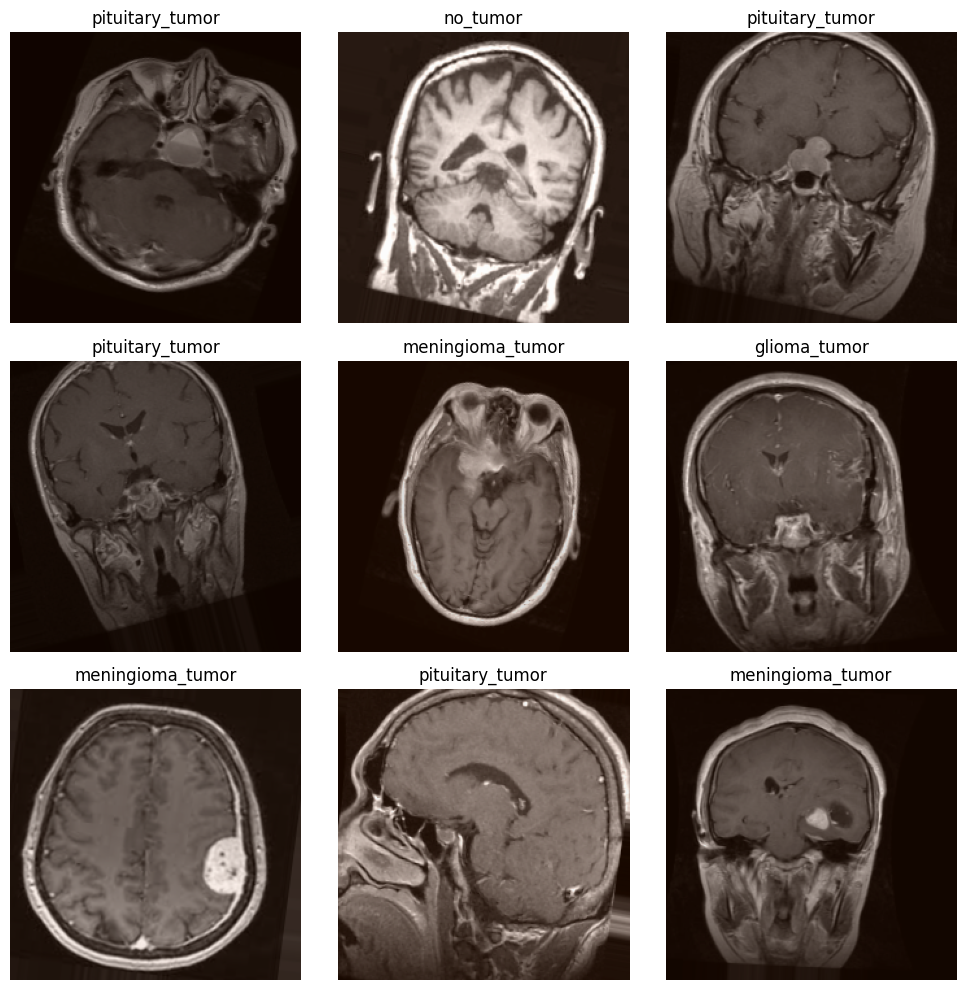

In [86]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Generadores de datos
train_generator, validation_generator = create_data_generators(X_train, y_train, X_valid, y_valid, batch_size=batch_size, augmentation=True)

# Mostrar imágenes de ejemplo desde el generador
visualize_images(train_generator, CATEGORIES)

In [87]:
images, labels = next(train_generator)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

print("Unique labels:", np.unique(labels))
print("Labels shape (before one-hot):", labels.shape)

if labels.ndim > 1:
    labels = np.argmax(labels, axis=1)


Images shape: (64, 224, 224, 3)
Labels shape: (64,)
Unique labels: [0 1 2 3]
Labels shape (before one-hot): (64,)


# Entrenamiento de Modelos con Arquitecturas: 
## VGG16, ResNET50, InceptionV3, DenseNet121, EfficientNet con aumentación de datos

#### Preparación de datos y entrenamiento

Creating and compiling VGG16...


Model: "functional_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_82 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 14,815,044 (56.51 MB)

 Non-trainable params: 0 (0.00 B)

Data batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5354 - loss: 1.0581 - val_accuracy: 0.7131 - val_loss: 0.6454 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8184 - loss: 0.5020 - val_accuracy: 0.8816 - val_loss: 0.3409 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9016 - loss: 0.2857 - val_accuracy: 0.9220 - val_loss: 0.2171 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9271 - loss: 0.2051 - val_accuracy: 0.9206 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9512 - loss: 0.1601 - val_accuracy: 0.8830 - val_loss: 0.3452 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9204 - loss: 0.2052 - val_accuracy: 0.8942 - val_loss: 0.3420 - learning_rate: 1.0000e-04
Epoch 7/50
34/

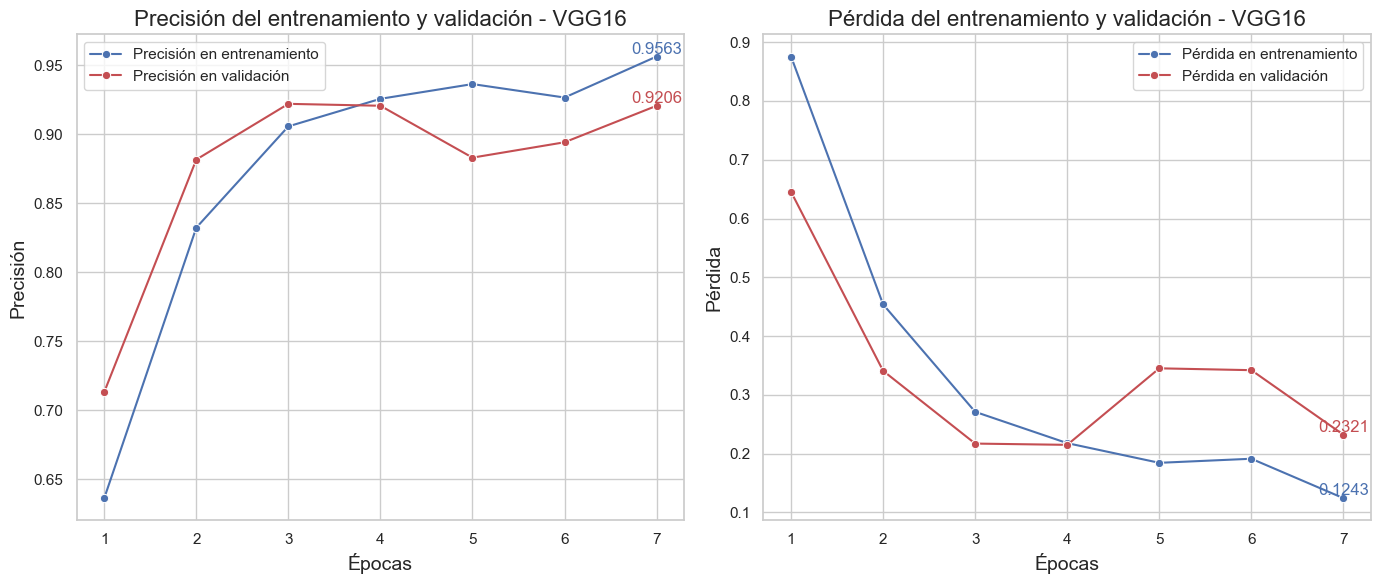

Creating and compiling ResNet50...


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_84 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │       401,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 23,936,004 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

Data batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.6077 - loss: 1.5168 - val_accuracy: 0.1086 - val_loss: 2.2988 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8971 - loss: 0.3830 - val_accuracy: 0.1086 - val_loss: 4.9796 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9277 - loss: 0.2223 - val_accuracy: 0.1086 - val_loss: 4.2887 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9545 - loss: 0.1403 - val_accuracy: 0.1086 - val_loss: 4.2640 - learning_rate: 5.0000e-05


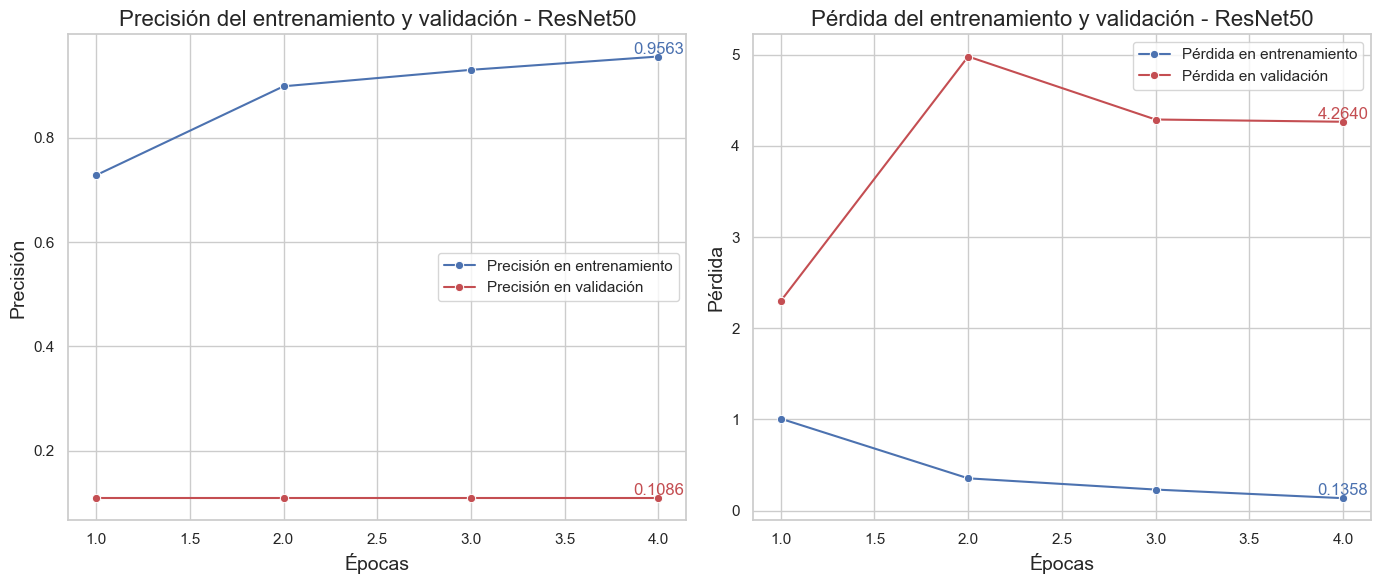

Creating and compiling DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_86 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │       200,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,238,212 (27.61 MB)

 Trainable params: 7,154,564 (27.29 MB)

 Non-trainable params: 83,648 (326.75 KB)

Data batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 828s 19s/step - accuracy: 0.5975 - loss: 1.1900 - val_accuracy: 0.4345 - val_loss: 2.5439 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 317s 9s/step - accuracy: 0.8952 - loss: 0.2915 - val_accuracy: 0.6240 - val_loss: 1.2997 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 949s 28s/step - accuracy: 0.9336 - loss: 0.1725 - val_accuracy: 0.7827 - val_loss: 0.6575 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 348s 9s/step - accuracy: 0.9456 - loss: 0.1440 - val_accuracy: 0.7688 - val_loss: 0.9006 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 297s 9s/step - accuracy: 0.9634 - loss: 0.1091 - val_accuracy: 0.8538 - val_loss: 0.5298 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 286s 8s/step - accuracy: 0.9673 - loss: 0.0799 - val_accuracy: 0.8872 - val_loss: 0.3727 - learning_rate: 1.0000e-04
Epoch 

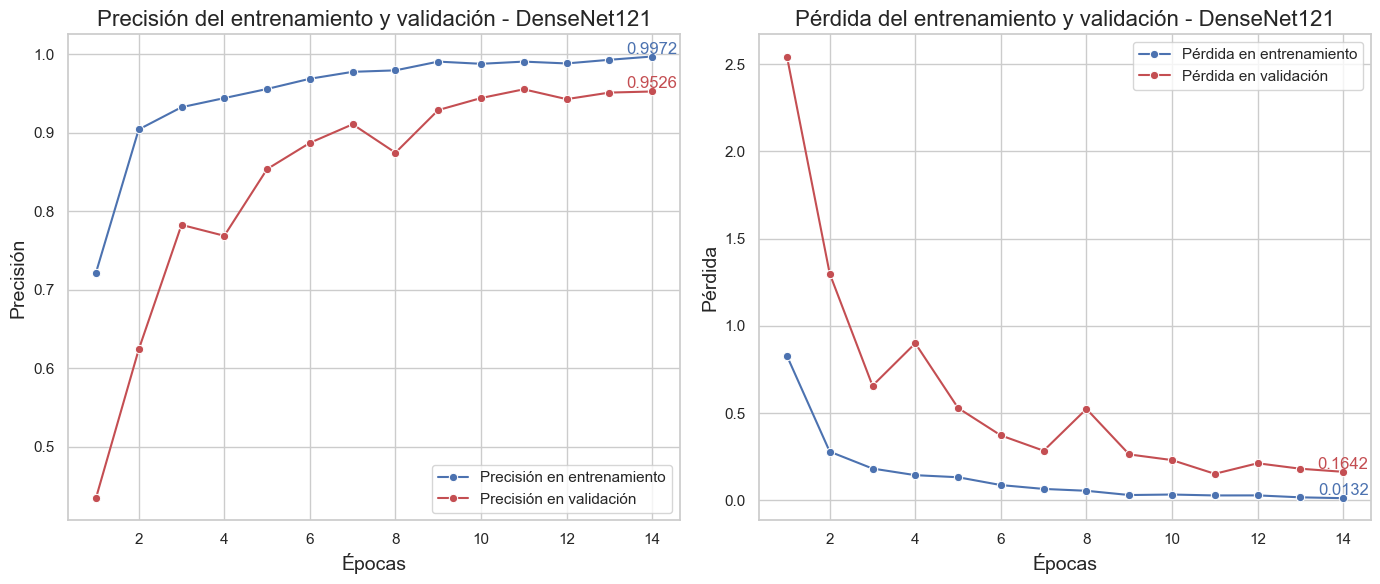

Creating and compiling EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,300,455 (16.40 MB)

 Trainable params: 4,258,432 (16.24 MB)

 Non-trainable params: 42,023 (164.16 KB)

Data batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 771s 18s/step - accuracy: 0.5218 - loss: 1.1754 - val_accuracy: 0.1086 - val_loss: 2.5228 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.8236 - loss: 0.4666 - val_accuracy: 0.1086 - val_loss: 2.4901 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.8833 - loss: 0.3204 - val_accuracy: 0.1086 - val_loss: 3.1409 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9081 - loss: 0.2576 - val_accuracy: 0.1086 - val_loss: 2.9532 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.9310 - loss: 0.2070 - val_accuracy: 0.1086 - val_loss: 2.9046 - learning_rate: 5.0000e-05


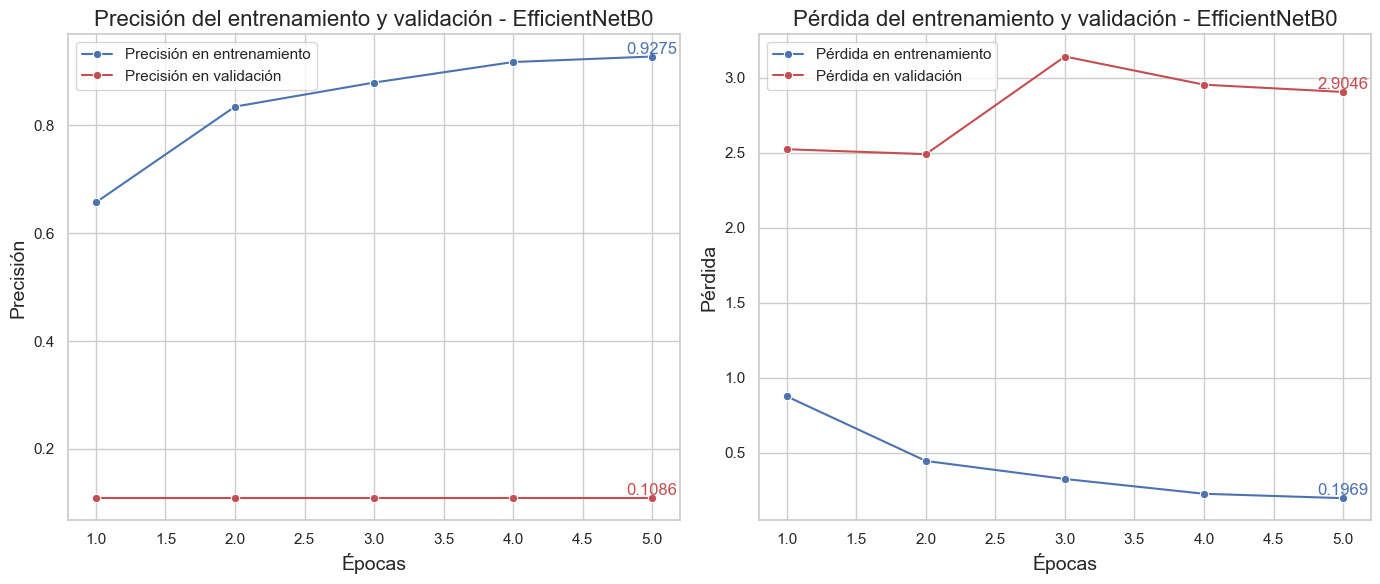

Creating and compiling InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_90 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │       204,804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,007,588 (83.95 MB)

 Trainable params: 21,973,156 (83.82 MB)

 Non-trainable params: 34,432 (134.50 KB)

Data batch shape: (64, 224, 224, 3)
Labels batch shape: (64,)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1014s 24s/step - accuracy: 0.5694 - loss: 1.0909 - val_accuracy: 0.5794 - val_loss: 1.3953 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.8359 - loss: 0.4596 - val_accuracy: 0.7423 - val_loss: 0.8935 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 161s 5s/step - accuracy: 0.9208 - loss: 0.2076 - val_accuracy: 0.8398 - val_loss: 0.5549 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step - accuracy: 0.9467 - loss: 0.1457 - val_accuracy: 0.8928 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.9543 - loss: 0.1136 - val_accuracy: 0.8663 - val_loss: 0.4324 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.9649 - loss: 0.1034 - val_accuracy: 0.8816 - val_loss: 0.3724 - learning_rate: 1.0000e-04
Epoch 

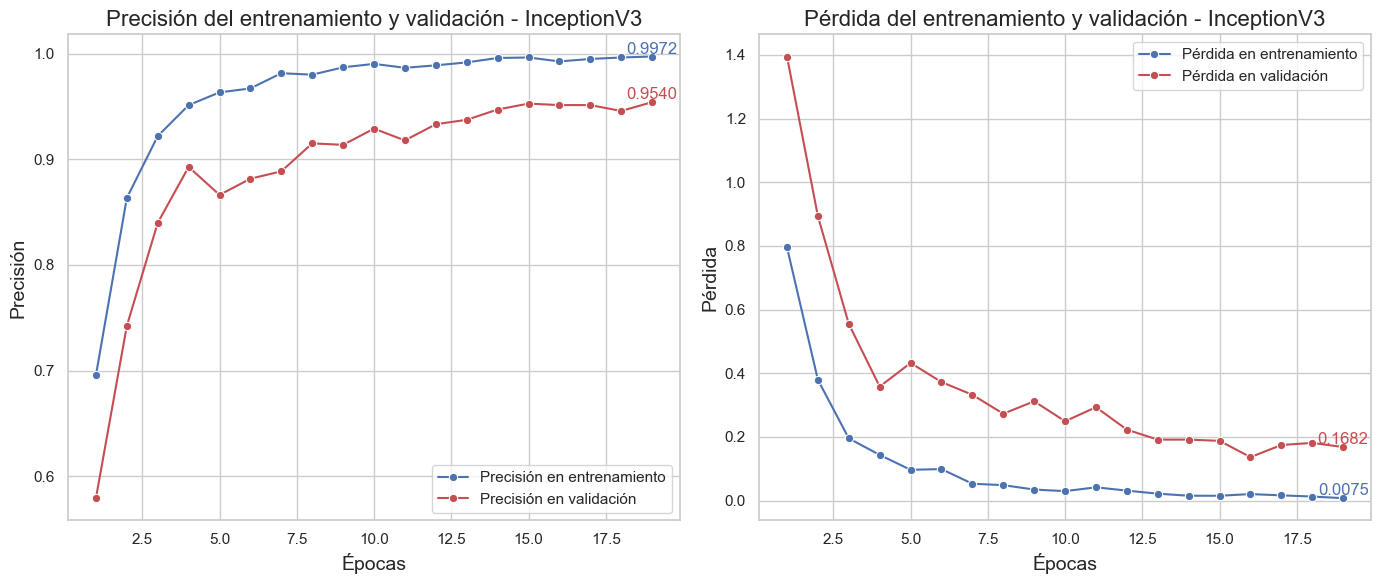

In [96]:
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, InceptionV3, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

num_classes = len(np.unique(y_train))
# Crear modelos
base_model_classes = {
    'VGG16': VGG16,
    'ResNet50': ResNet50,
    'DenseNet121': DenseNet121,
    'EfficientNetB0': EfficientNetB0,
    'InceptionV3': InceptionV3
}

for model_name, base_model_class in base_model_classes.items():
    print(f"Creating and compiling {model_name}...")
    model = create_model(base_model_class, num_classes)

     # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    model_checkpoint = ModelCheckpoint(f'models/{model_name}.keras', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    
    history = train_model(model, train_generator, validation_generator, epochs, callbacks=[early_stopping, model_checkpoint, reduce_lr], learning_rate=learning_rate, fine_tuning=True)
    
    plot_training_history(history, model_name)
